# Marker Model Training

In [1]:
%matplotlib inline
import os
import os.path as osp
import celldom
import pandas as pd
import numpy as np
from cvutils import rectlabel
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from celldom.config import marker_config
from celldom.dataset import marker_dataset
from mrcnn import model as mrcnn_model_lib
from mrcnn import visualize as mrcnn_viz
from celldom.dataset import utils as dataset_utils
from cvutils.mrcnn.session import init_keras_session
from celldom.warnings import disable_mrcnn_warnings
from cvutils.mrcnn import model as mrcnn_model
from celldom import seed

init_keras_session()
disable_mrcnn_warnings()
plt.gray()

dataset_name = 'dataset03'
dataset_dir = celldom.get_dataset_dir()
marker_data_dir = osp.join(dataset_dir, dataset_name, 'MarkerTraining')

model_dir = osp.join(celldom.get_model_dir(), 'marker_model')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

In [2]:
images = dataset_utils.get_data_files(marker_data_dir, patterns=['*.tif'])
print('Number of annotations found =', len(images))
images[:3]

Number of annotations found = 70


,image_name,image_path,annot_path,annot_exists
19,BF_ST_000_APT_000_z_0.tif,/lab/data/celldom/dataset/dataset03/MarkerTrai...,/lab/data/celldom/dataset/dataset03/MarkerTrai...,True
65,BF_ST_000_APT_000_zm3.tif,/lab/data/celldom/dataset/dataset03/MarkerTrai...,/lab/data/celldom/dataset/dataset03/MarkerTrai...,True
53,BF_ST_000_APT_000_zm6.tif,/lab/data/celldom/dataset/dataset03/MarkerTrai...,/lab/data/celldom/dataset/dataset03/MarkerTrai...,True


In [3]:
idx_train, idx_test = train_test_split(np.arange(len(images)), test_size=.3, random_state=seed)
assert len(idx_train) + len(idx_test) == len(images)
assert len(np.intersect1d(idx_train, idx_test)) == 0

image_paths_train = images['image_path'].iloc[idx_train].values#[[1]]
image_paths_test = images['image_path'].iloc[idx_test].values#[[0]]

In [4]:
#image_paths_train, image_paths_test

In [5]:
# from skimage import io
# plt.imshow(io.imread('/lab/data/celldom/dataset/dataset03/MarkerTraining/BF_ST_012_APT_000_zm6.tif'))

In [4]:
# import imp
# imp.reload(marker_dataset)

In [5]:
dataset_train = marker_dataset.MarkerDataset()
dataset_train.initialize(image_paths_train, ['Marker'])
dataset_train.prepare()

dataset_test = marker_dataset.MarkerDataset()
dataset_test.initialize(image_paths_test, ['Marker'])
dataset_test.prepare()

In [6]:
dataset_train.load_image(0).shape, dataset_train.load_image(0).dtype

((1024, 1376, 3), dtype('uint8'))

In [7]:
dataset_train.load_mask(0)[0].shape

(1024, 1376, 15)

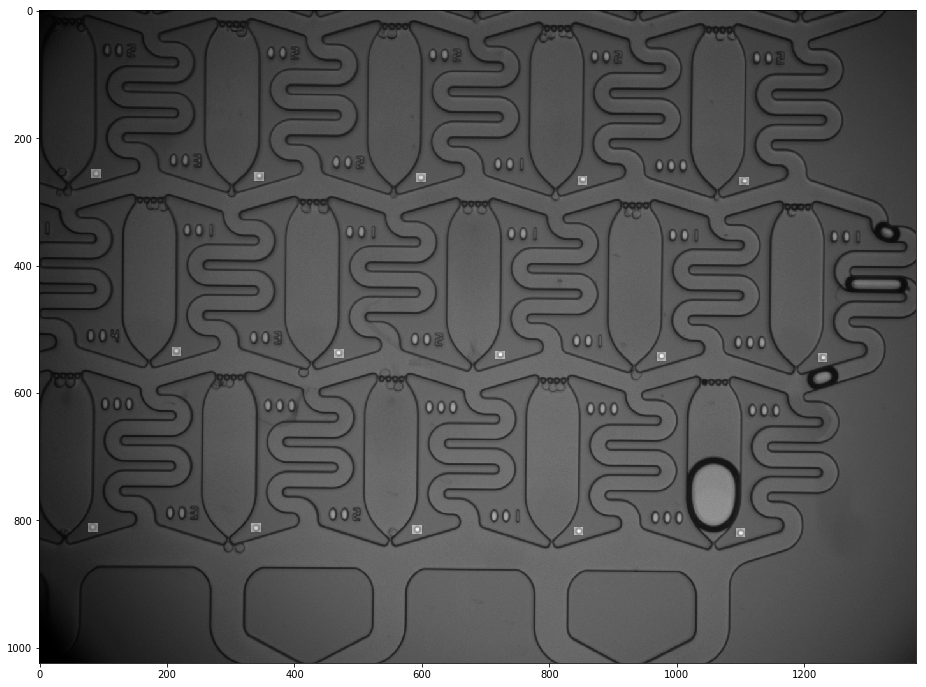

In [8]:
image_id = 0
alpha = .5
plt.imshow(
    dataset_train.load_image(image_id)[..., 0] + \
    alpha * 255 * dataset_train.load_mask(image_id)[0].max(axis=2)
)
plt.gcf().set_size_inches(16, 12)

In [9]:
# Fetch RCNN training configuration
train_config = marker_config.MarkerTrainingConfig()

# Set these step counts to equal data size so that a single epoch is easier to describe
train_config.STEPS_PER_EPOCH = len(image_paths_train)
train_config.VALIDATION_STEPS = len(image_paths_test)
    
train_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EXPECTED_CLASS_COUNTS          {'Marker': 1}
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1408
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1408 1408    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHA

In [10]:
model = mrcnn_model.get_model(mode="training", config=train_config, model_dir=model_dir, init_with='coco')

In [11]:
%%time

n_epochs = 15
model.train(
    dataset_train, dataset_test, 
    learning_rate=train_config.LEARNING_RATE, 
    epochs=n_epochs, 
    layers='heads'
)

Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 0. LR=0.001

Checkpoint Path: /lab/data/celldom/model/r0.2/marker_model/celldom-marker20180606T1321/mask_rcnn_celldom-marker_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeD

In [14]:
!find $model_dir | tail

/lab/data/celldom/model/r0.2/marker_model/celldom-marker20180606T1321/mask_rcnn_celldom-marker_0007.h5
/lab/data/celldom/model/r0.2/marker_model/celldom-marker20180606T1321/mask_rcnn_celldom-marker_0008.h5
/lab/data/celldom/model/r0.2/marker_model/celldom-marker20180606T1321/mask_rcnn_celldom-marker_0009.h5
/lab/data/celldom/model/r0.2/marker_model/celldom-marker20180606T1321/mask_rcnn_celldom-marker_0010.h5
/lab/data/celldom/model/r0.2/marker_model/celldom-marker20180606T1321/mask_rcnn_celldom-marker_0011.h5
/lab/data/celldom/model/r0.2/marker_model/celldom-marker20180606T1321/mask_rcnn_celldom-marker_0012.h5
/lab/data/celldom/model/r0.2/marker_model/celldom-marker20180606T1321/mask_rcnn_celldom-marker_0013.h5
/lab/data/celldom/model/r0.2/marker_model/celldom-marker20180606T1321/mask_rcnn_celldom-marker_0014.h5
/lab/data/celldom/model/r0.2/marker_model/celldom-marker20180606T1321/mask_rcnn_celldom-marker_0015.h5
/lab/data/celldom/model/r0.2/marker_model/marker_model.h5


In [15]:
model_path = osp.join(model_dir, 'marker_model.h5')
!cp /lab/data/celldom/model/r0.2/marker_model/celldom-marker20180606T1321/mask_rcnn_celldom-marker_0015.h5 $model_path
'Final model copied to result path "{}"'.format(model_path)

'Final model copied to result path "/lab/data/celldom/model/r0.2/marker_model/marker_model.h5"'

In [14]:
# model_path = '/lab/data/celldom/model/r0.2/marker_model/celldom-marker20180606T1147/mask_rcnn_celldom-marker_0015.h5'

## Inference

In [16]:
# Re-initialize model from exported weights in inference mode
inference_config = marker_config.MarkerInferenceConfig()

In [18]:
model = mrcnn_model.get_model('inference', inference_config, model_dir, init_with='file', file=model_path)

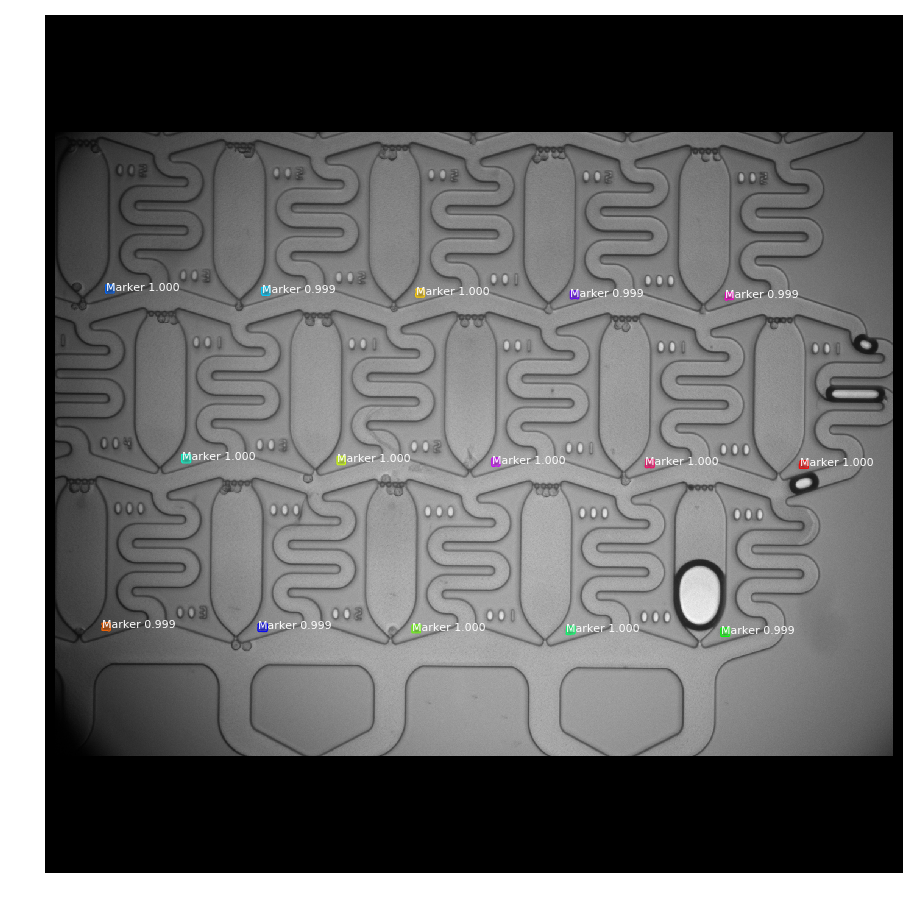

In [20]:
image_id = 9
image, image_meta, gt_class_id, gt_bbox, gt_mask = \
    mrcnn_model_lib.load_image_gt(
        dataset_test, inference_config, image_id,
        use_mini_mask=False
    )
r = model.detect([image])[0]
mrcnn_viz.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], show_bbox=False)

In [22]:
image.shape

(1408, 1408, 3)

In [21]:
image_meta

array([   9, 1024, 1376,    3, 1408, 1408,    3,  192,   16, 1216, 1392,
          1,    1,    1])

In [ ]:
# To validate mrcnn resizing:
# from mrcnn import utils as mrcnn_utils
# rsz_img_res, rsz_window, rsz_scale, rsz_padding, rsz_crop = mrcnn_utils.resize_image(rsz_img, min_dim=1024, max_dim=1408, min_scale=0)
# # image.astype(image_dtype), window, scale, padding, crop
# rsz_img_res.shape, rsz_window, rsz_scale, rsz_padding, rsz_crop